# Parallel MPW experiments (not the latest implementation)

NOTE: The MPW implemetation was just modified on Saturday 08/27. The experiment results, both the parallel one in this notebook and the sequential one in the paper submission, are based on the previous implementation. 

## 1. New implementation

The new implementation changes the order of for loops. It avoids repeatedly iterating linear extensions of a partial order. For 5 candidates and 5 voters, the sequantial MPW is about 15 times faster, and the parallel MPW is about 3 times faster.

```python
# Previous implementation
for state, count in state2count.items():
    for ranking in partialorder.linear_extension_iterator():
        state_new = compute_new_state(state, ranking)
        ...
        
# Latest implementation
for ranking in partialorder.linear_extension_iterator():
    for state, count in state2count.items():
        state_new = compute_new_state(state, ranking)
        ...
```

## 2. Experiment results w/ previous paralle MPW

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df_raw = pd.read_csv('experiment_output_explore.tsv', sep='\t', na_values='error').drop(columns=['phi', 'pmax', 'threads', 't_max_min'])
df_raw.replace('Plurality', 'plurality', inplace=True)

### 2.1 When instances became too hard to finish (for 48 CPU cores and 368GB RAM)

In [3]:
df_unfinished = df_raw[df_raw['t_mpw_s'].isna()].sort_values(by=['m', 'n']).drop(columns=['batch', 'mew', 't_mew_s']).drop_duplicates()
df_unfinished

,m,n,rule,mpw,t_mpw_s,error
917,7,4,Borda,NaN,NaN,unfinished-in-30-min
1091,7,5,Borda,NaN,NaN,unfinished-in-30-min
842,8,3,Borda,NaN,NaN,unfinished-in-30-min
872,9,2,Borda,NaN,NaN,unfinished-in-30-min
1082,9,3,Borda,NaN,NaN,unfinished-in-30-min
1088,10,2,Borda,NaN,NaN,out-of-memory


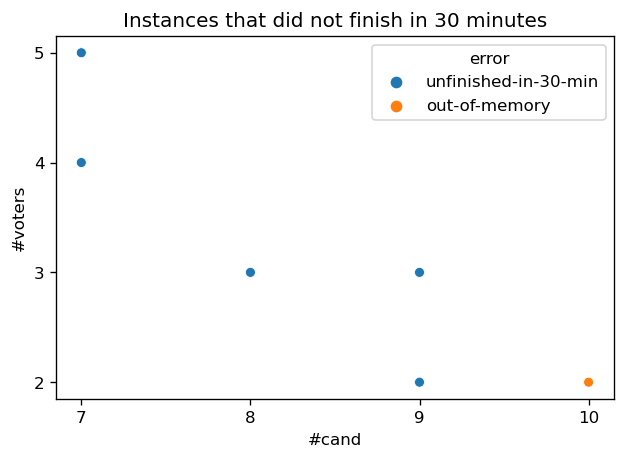

In [4]:
plt.figure(dpi=120)
sns.scatterplot(x='m', y='n', hue='error', data=df_unfinished)
plt.xticks(list(range(7, 11)))
plt.yticks(list(range(2, 6)))
plt.xlabel('#cand')
plt.ylabel('#voters')
plt.title('Instances that did not finish in 30 minutes');

Conclusion
- The #candidates cannot reach 10, because it is out-of-memory. The new implementation will encounter this issue as well.
- Assuem the new impelementation is 10 times faster. It is probably still hard to scale this experiment.

### 2.2 Paralle MPW vs Sequentail MPW

In [5]:
df_seq = pd.read_csv('../mpw/experiment_output.tsv', sep='\t').drop(columns=['phi', 'pmax', 'batch']).groupby(['m', 'n', 'rule'], as_index=False).mean()
df_seq.replace('Plurality', 'plurality', inplace=True)
df_parallel = df_raw.groupby(['m', 'n', 'rule'], as_index=False).mean().drop(columns='batch')
df = pd.merge(df_parallel, df_seq, on=['m', 'n', 'rule'], suffixes=['_parallel', '_sequential'])
df['Speedup for MPW'] = df['t_mpw_s_sequential'] / df['t_mpw_s_parallel']
df['Speedup for MEW'] = df['t_mew_s_sequential'] / df['t_mew_s_parallel']
df = df[['m', 'n', 'rule', 't_mpw_s_parallel', 't_mpw_s_sequential', 'Speedup for MPW', 't_mew_s_parallel', 't_mew_s_sequential', 'Speedup for MEW']]
df.rename(columns={'t_mpw_s_parallel': 'parallel MPW time (s)', 't_mpw_s_sequential': 'sequential MPW time (s)', 
                   't_mew_s_parallel': 'parallel MEW time (s)', 't_mew_s_sequential': 'sequential MEW time (s)'}, 
          inplace=True)
df

,m,n,rule,parallel MPW time (s),sequential MPW time (s),Speedup for MPW,parallel MEW time (s),sequential MEW time (s),Speedup for MEW
0,3,5,2-approval,0.783139,0.001770,0.002261,0.076883,0.001154,0.015012
1,3,5,Borda,0.783678,0.003812,0.004864,0.077355,0.002164,0.027981
2,3,5,plurality,0.781660,0.001634,0.002090,0.077202,0.001587,0.020554
3,4,5,2-approval,0.932828,0.025449,0.027282,0.093218,0.003126,0.033534
4,4,5,Borda,0.954652,0.245749,0.257423,0.094468,0.003118,0.033004
5,4,5,plurality,0.934812,0.013579,0.014526,0.092725,0.002286,0.024658
6,5,1,2-approval,0.143805,0.001180,0.008209,0.072569,0.001116,0.015375
7,5,1,Borda,0.143635,0.001227,0.008542,0.073064,0.001266,0.017327
8,5,1,plurality,0.144423,0.001189,0.008229,0.072807,0.001030,0.014144
9,5,2,2-approval,0.291558,0.007835,0.026874,0.073177,0.002146,0.029326


Conclusion
- The parallel MPW can speed up the computation for hard cases where the sequential MPW needs > 1 second.
- The parallel MEW is not faster than sequential MEW in these cases because the workload is small for MEW.